## CASE STUDY - NYC Restaurant Inspection Risk Classification

### Index

1. [Objective](#objective-test)  
2. [Packages to install](#packages-install)
3. [Import Packages](#import-packages)  
3. [Data Exploration & Cleaning](#data-exploration--cleaning)  
4. [Feature Engineering](#feature-engineering)  
5. [Model / Solution Approach](#model--solution-approach)  
6. [Results & Evaluation](#results--evaluation)  
7. [Conclusion & Next Steps](#conclusion--next-steps)

**Tasks:**
  * Load & Filter: Select columns, drop entries without risk_category.
  * Text & Categorical Prep: Clean violation_code & action, encode borough & month.
  * Modeling: Predict risk_category (Low/Moderate/High) with multiclass classifier; handle imbalance.
  * Evaluation & Visualization: Report accuracy, macro-F1, confusion matrix; map high-risk by borough.
  * Takeaways: Identify violation codes predicting high risk.

**Bonus (Generative AI):**

  Prompt GPT to draft health department alerts for rising high-risk areas.

**Deliverables:**
 * Jupyter Notebook with code and analysis.
 * 5–7-slide Deck summarizing approach and results.
 * README with setup & execution instructions.

## Import Packages <a id="import-packages"></a>

In [1]:
import sys
import os

repo_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

src_path = os.path.join(repo_root, 'src')
data_path = os.path.join(repo_root, 'data')

# Add src/ to sys.path
if src_path not in sys.path:
    sys.path.append(src_path)

# Add data/ to sys.path
if data_path not in sys.path:
    sys.path.append(data_path)

In [2]:
import re
import warnings
import requests
import json

import pandas as pd
import seaborn as sns

import plotly.express as px
from matplotlib.lines import Line2D

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from utils import missing_data, clean_text_generic
from llm_call import classify_violations_llm
from plots import plot_box_plot, plot_corr_heatmap, plot_paralel_bar_plot
from config import MISTRAL_API_ENDPOINT, HEADERS, CSV_FILE

warnings.filterwarnings('ignore')

## 1. Load And Filter

### 1.1. Load data and initial glance to the data

In [3]:
# Load and drop duplicates
data_inspections = pd.read_csv(os.path.join(data_path, CSV_FILE)).drop_duplicates()
print(f"Initial dataset shape: {data_inspections.shape}")
data_inspections.info()

# there camis and date_inspection that have two different scores, i just the one that appears twice
data_inspections = data_inspections.drop(index=72959)

# Show missing data report
missing_data(data_inspections)

Initial dataset shape: (99996, 27)
<class 'pandas.core.frame.DataFrame'>
Index: 99996 entries, 0 to 99999
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   camis                  99996 non-null  int64  
 1   dba                    99993 non-null  object 
 2   boro                   99996 non-null  object 
 3   building               99791 non-null  object 
 4   street                 99991 non-null  object 
 5   zipcode                98965 non-null  float64
 6   phone                  99993 non-null  object 
 7   cuisine_description    98231 non-null  object 
 8   inspection_date        99996 non-null  object 
 9   action                 98231 non-null  object 
 10  violation_code         97397 non-null  object 
 11  violation_description  97397 non-null  object 
 12  critical_flag          99996 non-null  object 
 13  score                  93971 non-null  float64
 14  grade                  4

,Total,Percent
location_point1,99995,100.000000
grade_date,54662,54.664733
grade,51870,51.872594
score,6025,6.025301
violation_code,2599,2.599130
violation_description,2599,2.599130
bin,1777,1.777089
cuisine_description,1765,1.765088
action,1765,1.765088
inspection_type,1765,1.765088


### 1.2. Define risk_category & drop entries without risk_category

Based on information available online regarding this public data mainly what is present in this sites:
 * https://data.cityofnewyork.us/Health/2019-New-York-City-Restaurant-Inspection-Results/8we4-p22f/about_data
 * https://www.nyc.gov/assets/doh/downloads/pdf/rii/restaurant-grading-faq.pdf
 * https://www.nyc.gov/assets/doh/downloads/pdf/rii/blue-book.pdf

Based on documentation is stated that there is discrepancies between score and grade, and also grade has a lot of missing values,
so I decided to not over complicate the use-case and delete it. And also, Score is qualitative and has just 6% of missing values from here we can create risk_Category based on documentation that says:

  * Score 0–13 → Low Risk of Inspection
  * Score 14–27 → Medium Risk of Inspection
  * Score 28+ → High Risk of Inspection

Based also in documentation Score field is a sum of values from critical and general violations.

#### Extra: Analyse dicrepancies between grade and score

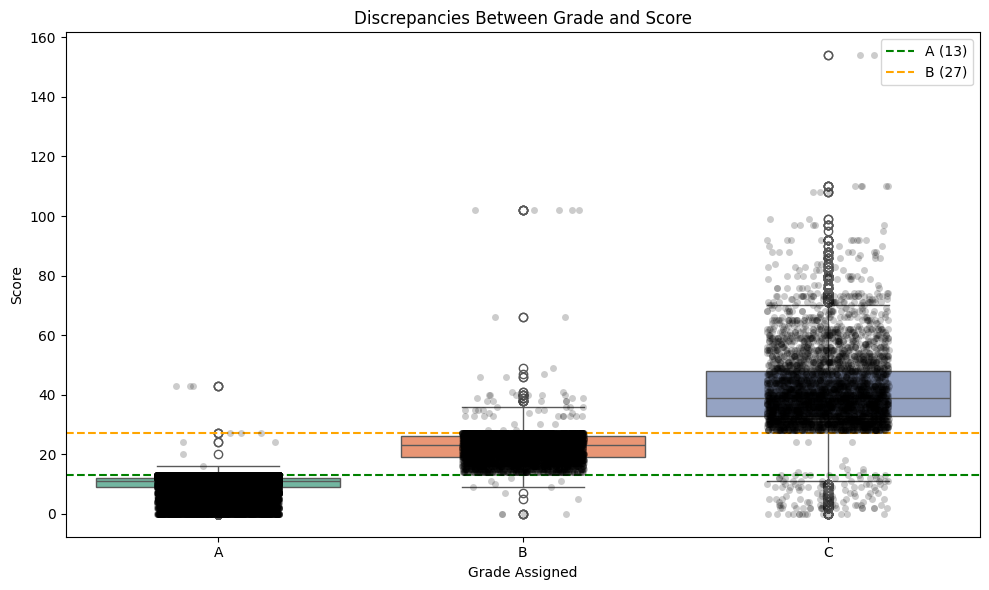

In [4]:
df_grade_score = data_inspections[data_inspections['grade'].isin(['A', 'B', 'C']) & data_inspections['score'].notnull()].copy()
plot_box_plot(df_grade_score)

#### 1.2.1 Create risk category

In [5]:
def classify_risk(score):
    if score <= 13:
        return 'Low'
    elif 14 <= score <= 27:
        return 'Moderate'
    else:
        return 'High'

print(f"Initial shape {data_inspections.shape} with this # restaurants {data_inspections.camis.nunique()}")
# lets drop grade and grade date based on initial justification
data_inspections = data_inspections.drop(columns=["grade", "grade_date"])

# drop entries without score
data_inspections = data_inspections.dropna(subset=['score'])
# create risk_category from score
data_inspections.loc[:, 'risk_category'] = data_inspections['score'].apply(classify_risk)

print(f"After initial cleaning shape {data_inspections.shape} with this # restaurants {data_inspections.camis.nunique()}")

Initial shape (99995, 27) with this # restaurants 26332
After initial cleaning shape (93970, 26) with this # restaurants 24378


### 1.3. Select columns with some EDA

The columns that are going to be deleted that seem not relevant for the use case:
* _dba_, _camis_, _phone_, _street_, _building_, _zipcode_ -> privacy information of the location and business data
*  _location_point1_ -> a lot of null values
* _score_ - because already transformed in _risk_category_ column
* _record_date_  - The date when the extract was run to produce this data set (also there is only two dates, one of then with
* Almost all locations related will be deleted 

#### Extra: EDA from some columns drop

In [6]:
data_inspections.record_date.value_counts()

record_date
2025-07-21T06:00:14.000    93916
2025-07-21T06:00:16.000       54
Name: count, dtype: int64

There are a lot of location variables overlap, probably only geographical variables and boro for geographical space.
And having a lot of sparsed dummy varibales if encoded can lead to overfit, not generalize, and over complex the model. Also due to privacy of specific locations or business.

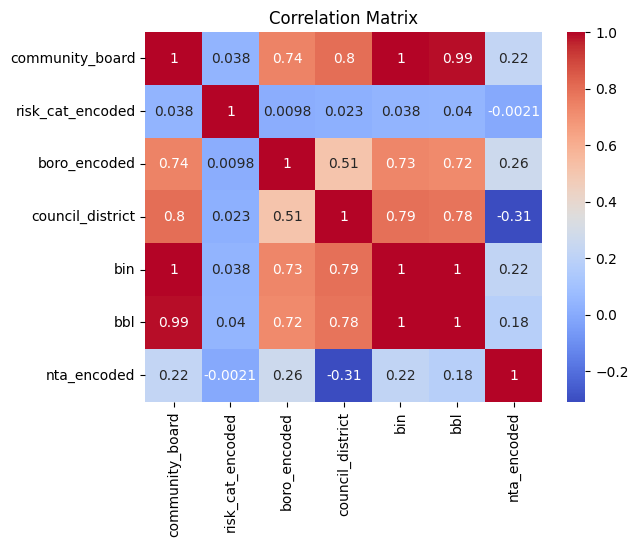

In [7]:
# Correlation matrix - boro seems enough for this problem
location_cols = ['boro', 'community_board', 'council_district', 'bin', 'bbl', 'nta']
df_location = data_inspections[location_cols + ['risk_category']]

boro_order = {'Manhattan': 0, 'Brooklyn': 1, 'Queens': 2, 'Bronx': 3, 'Staten Island': 4}
df_location['boro_encoded'] = df_location['boro'].map(boro_order)

risk_map = {'Low': 0, 'Moderate': 1, 'High': 2}
df_location['risk_cat_encoded'] = df_location['risk_category'].map(risk_map)

le_nta = LabelEncoder()
df_location['nta_encoded'] = le_nta.fit_transform(df_location['nta'].astype(str))

corr_cols = ['community_board', 'risk_cat_encoded', 'boro_encoded', 'council_district', 'bin', 'bbl', 'nta_encoded']
plot_corr_heatmap(df_location, corr_cols)


#### 1.3.1 Select columns

In [8]:
cols_to_drop = ["dba", "record_date", "location_point1", "census_tract", "phone", "score", "building", "street", "zipcode", "bin", "bbl", "street", "community_board", "council_district", "nta"]
cols_to_extra_analysis = ["latitude", "longitude"]
data_final = data_inspections.drop(columns=cols_to_drop).drop_duplicates()
data_final.info()

missing_data(data_final)

<class 'pandas.core.frame.DataFrame'>
Index: 93970 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   camis                  93970 non-null  int64  
 1   boro                   93970 non-null  object 
 2   cuisine_description    93970 non-null  object 
 3   inspection_date        93970 non-null  object 
 4   action                 93970 non-null  object 
 5   violation_code         93439 non-null  object 
 6   violation_description  93439 non-null  object 
 7   critical_flag          93970 non-null  object 
 8   inspection_type        93970 non-null  object 
 9   latitude               93845 non-null  float64
 10  longitude              93845 non-null  float64
 11  risk_category          93970 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 9.3+ MB


,Total,Percent
violation_code,531,0.565074
violation_description,531,0.565074
latitude,125,0.133021
longitude,125,0.133021
camis,0,0.000000
boro,0,0.000000
cuisine_description,0,0.000000
inspection_date,0,0.000000
action,0,0.000000
critical_flag,0,0.000000


## 2. Text & Categorical Prep

### 2.1.  EDA: New features need to be created?

Before transforming the dataset for modeling, it's important to understand how the score and risk_category are derived. To do this, I first examined whether multiple rows exist for the same restaurant (camis) and inspection date. These duplicates typically reflect multiple violations recorded during a single inspection. Understanding this structure is key, as the number and severity of violations likely influence the final risk_category. (I will show this later)

**Plot analysis**
I created a parallel boxplot of unique values per inspection, grouped by camis and inspection_date. The plot validated my assumption: certain columns remain constant within an inspection (e.g., inspection_type, action), while others vary (e.g., violation_code, critical_flag), reflecting multiple violations.


Based on this analysis, the data transformation approach will be:
* Categorical features like inspection_type and action will be one-hot or ordinal encoded, as they are single values per inspection.
* violation_code and critical_flag will be aggregated into summary features (e.g., total violations, number of critical flags).

The end goal is to transform the dataset so that each row represents one inspection per restaurant, with engineered features and a single risk_category label.

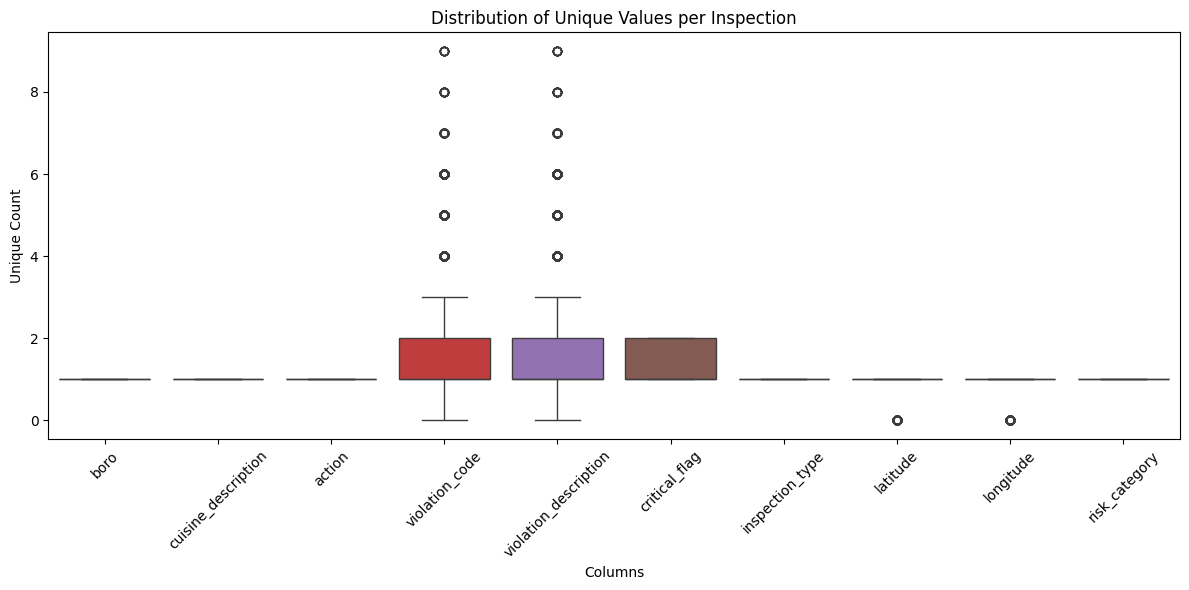

In [9]:
inspection_uniques = data_final.groupby(['camis', 'inspection_date']).nunique()
plot_paralel_bar_plot(inspection_uniques)

### 2.2. Clean features

In [10]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93970 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   camis                  93970 non-null  int64  
 1   boro                   93970 non-null  object 
 2   cuisine_description    93970 non-null  object 
 3   inspection_date        93970 non-null  object 
 4   action                 93970 non-null  object 
 5   violation_code         93439 non-null  object 
 6   violation_description  93439 non-null  object 
 7   critical_flag          93970 non-null  object 
 8   inspection_type        93970 non-null  object 
 9   latitude               93845 non-null  float64
 10  longitude              93845 non-null  float64
 11  risk_category          93970 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 9.3+ MB


##### 2.2.1 **Clean violation_code**

In [11]:
#  I want to understand if critical and violation code were 1-to-1 and they are actually are.
analysis_violation_code = data_final.groupby(['violation_code']).critical_flag.nunique().reset_index()
analysis_violation_code.critical_flag.value_counts()

# there is a violation_code with two flags. Lets fix it based on documentation https://www.nyc.gov/assets/doh/downloads/pdf/rii/blue-book.pdf and distribution -> to be Not Critical instead of Not Critical
clean_violation_code = data_final[data_final.violation_code == "09A"]
clean_violation_code.critical_flag.value_counts()

clean_violation_code[clean_violation_code.critical_flag == "Critical"].violation_description.unique()# "09A"

# check that for the same violation description there is two critical flags
# value_ = 'Swollen, leaking, rusted or otherwise damaged canned food to be returned to distributor not segregated from intact product and clearly labeled DO NOT USE'
# clean_violation_code[clean_violation_code.violation_description.str.contains(value_)].head()

# lets clean this
data_final.loc[data_final['violation_code'] == '09A', 'critical_flag'] = 'Not Critical'

##### 2.2.2. **Clean violation_descrition**

In [12]:
print("Unique nb violation description BEFORE cleaning", data_final['violation_description'].nunique())
data_final['violation_description'] = data_final['violation_description'].apply(clean_text_generic)
print("Unique nb violation description AFTER cleaning", data_final['violation_description'].nunique())

Unique nb violation description BEFORE cleaning 139
Unique nb violation description AFTER cleaning 122


### 2.3. Transform and create new columns

##### 2.3.1. **Create inspection date**

I will extract some date features for analyse

In [22]:
data_final['inspection_date'] = pd.to_datetime(data_final['inspection_date'])
data_final['year'] = data_final['inspection_date'].dt.year
data_final['month'] = data_final['inspection_date'].dt.month
data_final['day_of_week'] = data_final['inspection_date'].dt.dayofweek 

##### 2.3.2. **Create past nb inspections**
So for this use case I thought that creating a new feature with the number of past inspections because for that restaurant it can have a bigger probabily of having more inspections or if you never had one (so your first) or if you had a lot of then - having a lot can indicate that is a restaurant with a lot of problems.

I will analyse this later by comparing with the remaining features.

In [31]:
# to get nb_past_interventions
inspection_df = data_final[['camis', 'inspection_date']].drop_duplicates()
inspection_df = inspection_df.sort_values(['camis', 'inspection_date'])
inspection_df['nb_past_inspections'] = inspection_df.groupby('camis').cumcount()
# merge to the original one
data_final = data_final.merge(inspection_df, on=['camis', 'inspection_date'], how='left')

##### 2.3.3. **Create violation_category from violation_description using an LLM**


In [24]:
codes_df = (
    data_final[["violation_code", "violation_description"]]
    .dropna()
    .drop_duplicates()
    .groupby("violation_code")["violation_description"]
    .agg("; ".join)
    .reset_index()
)
violation_dict = codes_df.set_index("violation_code")["violation_description"].to_dict()

In [27]:
PROMPT = f"""
    You are classifying NYC restaurant health violation descriptions into concise categories.
    Group the following items into categories and give each category a name. Return the result as JSON.
    "{violation_dict}"
    return only json key is the category and for each category a dictionary with violation code and the respective original violation description.
    """

json_violations = classify_violations_llm(PROMPT, api_endpoint=MISTRAL_API_ENDPOINT, headers=HEADERS)

In [48]:
rows = [
    {
        "violation_category": category,
        "violation_code": code,
        "violation_description_llm": description
    }
    for category, violations in json_violations.items()
    for code, description in violations.items()
]

data_codes = pd.DataFrame(rows)
data_final = data_final.merge(data_codes[["violation_code", "violation_category"]], on="violation_code", how="left")

##### 2.3.4. **Group data and create new columns**

Here i am grouping by camis and inspection_date because of what already mentioned and creating some new features, like the nb of critical from the total nb of violations.

In [32]:
data_transformed = data_final.groupby(['camis', 'inspection_date'], as_index=False).agg(
    boro=('boro', 'first'),
    cuisine_description=('cuisine_description', 'first'),
    action=("action", "first"),
    nb_violations=('violation_code', 'count'),
    nb_critical_flags=('critical_flag', lambda x: sum(x == 'Critical')),
    inspection_type=('inspection_type', 'first'),
    nb_past_inspections=('nb_past_inspections', 'first'),
    risk_category=('risk_category', 'first'),
    month=('month', 'first'),
    year=('year', 'first'),
    day_of_week=('day_of_week', 'first')
)

In [34]:
data_transformed.head()

,camis,inspection_date,boro,cuisine_description,action,nb_violations,nb_critical_flags,inspection_type,nb_past_inspections,risk_category,month,year,day_of_week
0,30075445,2023-01-31,Bronx,Bakery Products/Desserts,Establishment Closed by DOHMH. Violations were...,2,2,Cycle Inspection / Initial Inspection,0,Moderate,1,2023,1
1,30075445,2023-08-01,Bronx,Bakery Products/Desserts,Violations were cited in the following area(s).,1,1,Cycle Inspection / Initial Inspection,1,High,8,2023,1
2,30075445,2024-11-08,Bronx,Bakery Products/Desserts,Violations were cited in the following area(s).,2,1,Cycle Inspection / Initial Inspection,2,Low,11,2024,4
3,30191841,2024-11-20,Manhattan,Irish,Violations were cited in the following area(s).,2,1,Cycle Inspection / Initial Inspection,0,Moderate,11,2024,2
4,40356483,2022-01-24,Brooklyn,Sandwiches,Violations were cited in the following area(s).,2,1,Cycle Inspection / Re-inspection,0,Low,1,2022,0


### 2.4. EDA analysis with risk_category

Before doing encoding of the categorical features, let's do an analysis with risk_category to understand if all features are important.

##### 2.4.1. **Analyse violation code**

Violation code seems to be the feature with the most relevance for the final use_case 

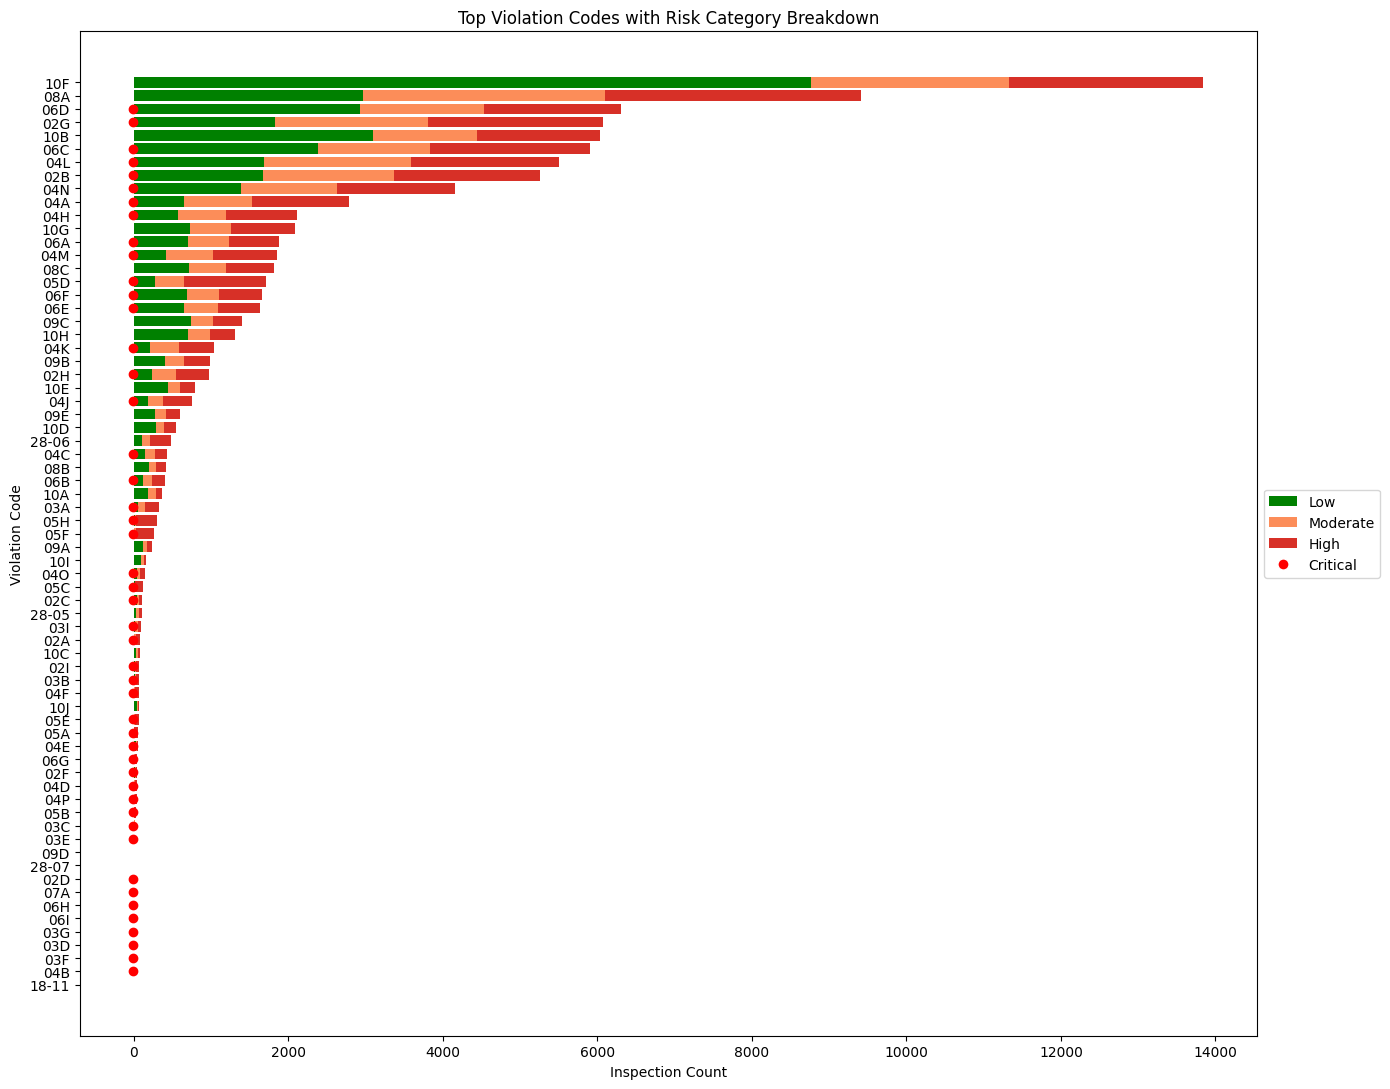

In [35]:
violation_risk_dist = (
    data_final.groupby(['violation_code', 'risk_category'])
    .size()
    .unstack(fill_value=0)
)

# Step 2: Keep top N violation codes
top_violation_codes = data_final['violation_code'].value_counts().index
violation_risk_dist = violation_risk_dist.loc[violation_risk_dist.index.isin(top_violation_codes)]

# Step 3: Reorder by total
violation_risk_dist = violation_risk_dist.loc[violation_risk_dist.sum(axis=1).sort_values(ascending=True).index]

# Step 4: Map critical violations
violation_critical_map = data_final.groupby('violation_code')['critical_flag'] \
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')

# Step 5: Plot
plt.figure(figsize=(14, 11))

bars = []
bottom = pd.Series([0] * len(violation_risk_dist), index=violation_risk_dist.index)

colors = {
    'High': '#d73027',
    'Moderate': '#fc8d59',
    'Low': 'green'
}

# Draw stacked bars
for risk in ['Low', 'Moderate', 'High']:
    bar = plt.barh(
        y=violation_risk_dist.index,
        width=violation_risk_dist[risk],
        left=bottom,
        label=risk,
        color=colors[risk]
    )
    bottom += violation_risk_dist[risk]
    bars.append(bar)

# Step 6: Draw red circles next to bar for critical violations
for i, vc in enumerate(violation_risk_dist.index):
    if violation_critical_map.get(vc) == 'Critical':
        plt.plot(-5, i, 'o', color='red')  # draw circle left of the bar

# Step 7: Format
plt.title('Top Violation Codes with Risk Category Breakdown')
plt.xlabel('Inspection Count')
plt.ylabel('Violation Code')
plt.legend(title='Risk Category')

# Custom legend for red circle
critical_legend = Line2D([0], [0], marker='o', color='w', label='Critical',
                         markerfacecolor='red', markersize=8)
plt.legend(handles=[*bars, critical_legend], loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

##### 2.4.2. **Analyse critical flags, nb_violations and nb_past_inspections**

Analyse critical flag with risk category and the number of it

In [36]:
data_transformed['nb_non_critical_flags'] = data_transformed['nb_violations'] - data_transformed['nb_critical_flags']
fig = px.scatter(
    data_transformed,
    x="nb_critical_flags",
    y="nb_non_critical_flags",
    size="nb_violations",
    color="risk_category",
    hover_data=["camis"],
    labels={
        "nb_critical_flags": "Number of Critical Violations",
        "nb_non_critical_flags": "Number of Non-Critical Violations",
        "nb_violations": "Total Violations"
    },
    title="Relationship between nb of critical and non critical Violations by Risk Category"
)

fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))
fig.show()

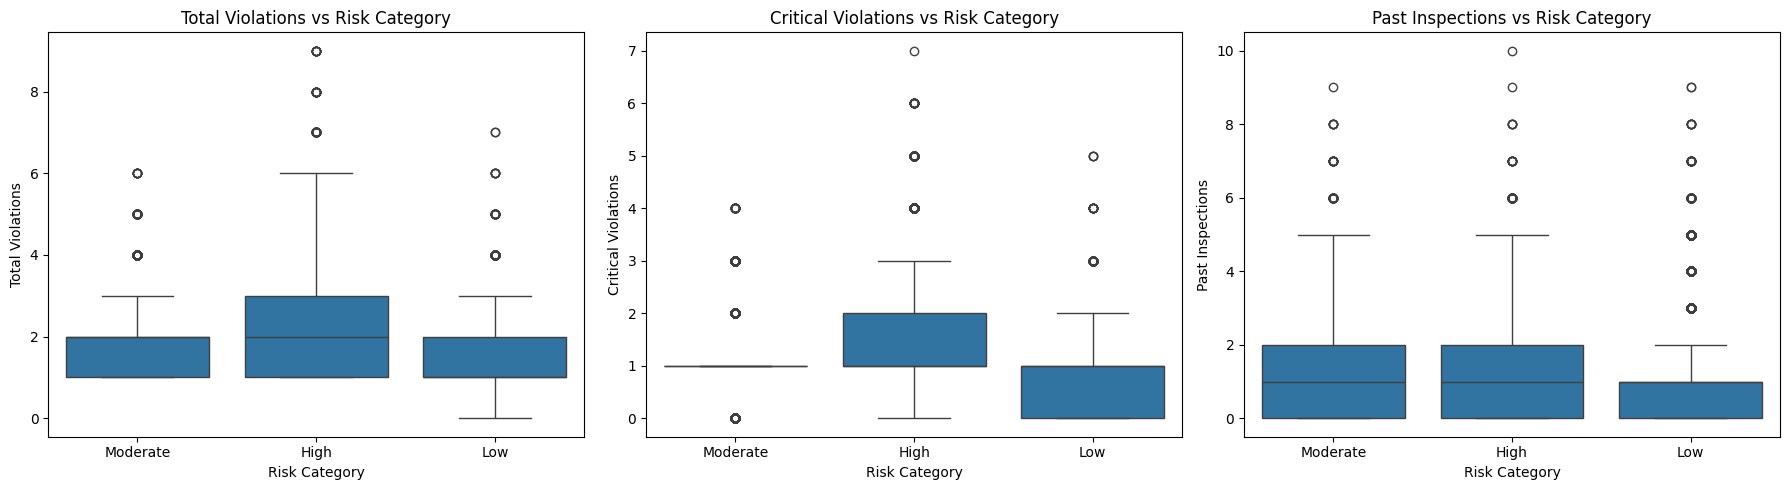

In [37]:
cols = ['nb_violations', 'nb_critical_flags', 'nb_past_inspections']
titles = ['Total Violations', 'Critical Violations', 'Past Inspections']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)  # 1 row, 3 columns

for i, col in enumerate(cols):
    sns.boxplot(data=data_transformed, x='risk_category', y=col, ax=axes[i])
    axes[i].set_title(f'{titles[i]} vs Risk Category')
    axes[i].set_xlabel('Risk Category')
    axes[i].set_ylabel(titles[i])

plt.tight_layout()
plt.show()

##### 2.4.3. **Analyse boro**

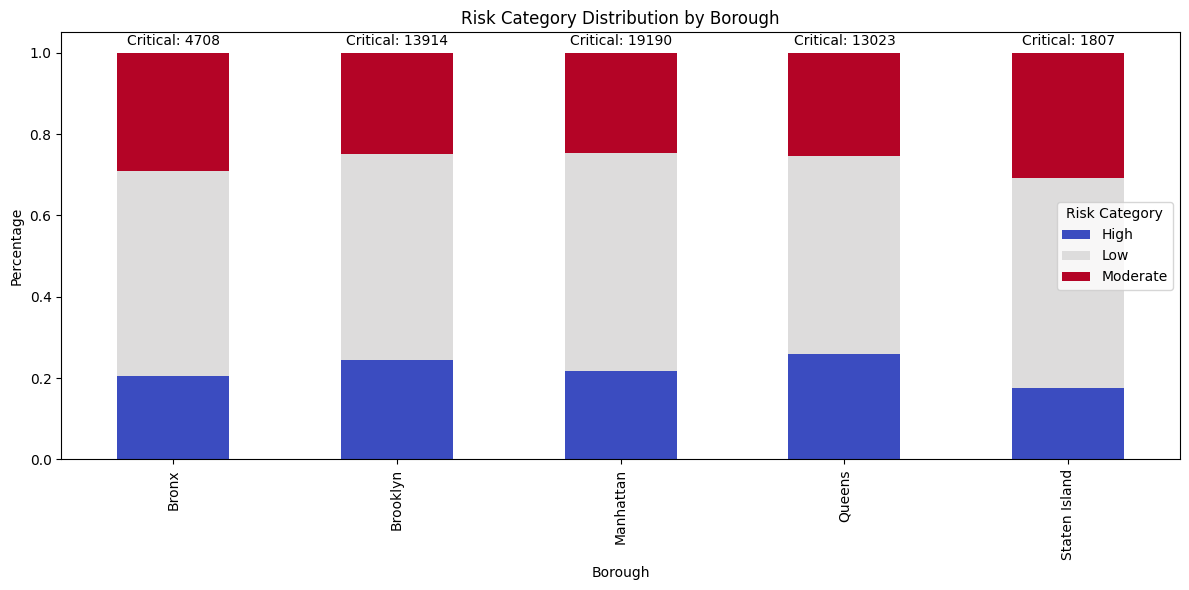

In [38]:
boro_dist = pd.crosstab(data_transformed['boro'], data_transformed['risk_category'], normalize='index')
critical_counts = data_transformed.groupby('boro')['nb_critical_flags'].sum()

# Plot stacked bar chart with increased figure size
fig, ax = plt.subplots(figsize=(12, 6))  # Make figure larger here

boro_dist.plot(kind='bar', stacked=True, colormap='coolwarm', ax=ax)

# Add title and labels
plt.title("Risk Category Distribution by Borough")
plt.ylabel("Percentage")
plt.xlabel("Borough")
plt.legend(title="Risk Category")

for i, boro in enumerate(boro_dist.index):
    value = critical_counts.get(boro, 0)
    ax.text(i, 1.02, f"Critical: {int(value)}", ha='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()


##### 2.4.4. **Analyse action**

In [39]:
action_map = {
    "Violations were cited in the following area(s).": "Violations Cited",
    "Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.": "Closed - Violations",
    "Establishment re-opened by DOHMH.": "Reopened",
    "No violations were recorded at the time of this inspection.": "No Violations",
    "Establishment re-closed by DOHMH.": "Re-closed"
}

data_transformed['action_simplified'] = data_transformed['action'].map(action_map)

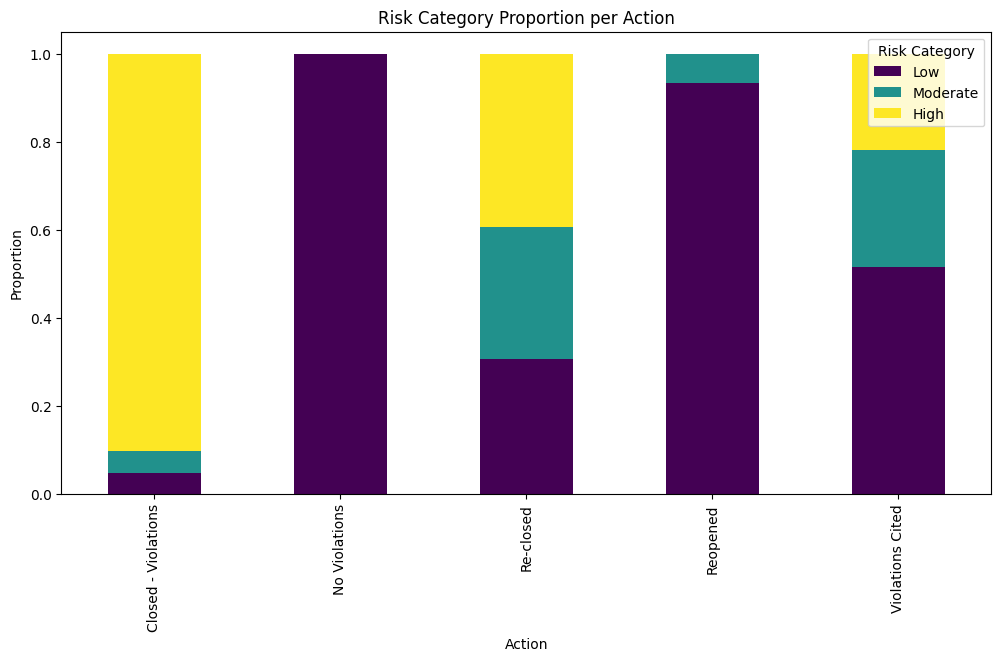

In [40]:
# Actions by risk category (stacked bar)
actions_risk = pd.crosstab(data_transformed['action_simplified'], data_transformed['risk_category'], normalize='index')
actions_risk[['Low', 'Moderate', 'High']].plot(kind='bar', stacked=True, figsize=(12,6), colormap='viridis')
plt.title("Risk Category Proportion per Action")
plt.xlabel("Action")
plt.ylabel("Proportion")
plt.legend(title="Risk Category")
plt.show()

##### 2.4.5. **Analyse cuisine description**

In [41]:
data_transformed['cuisine_description'].nunique()

88

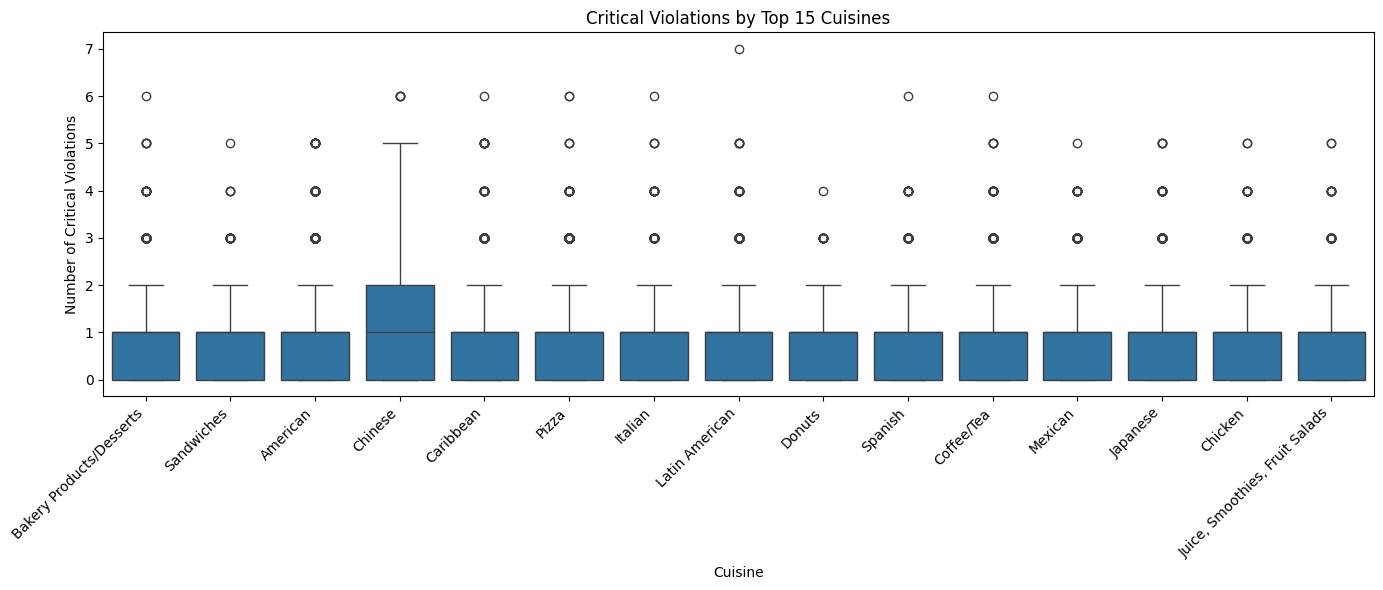

In [42]:
# Get top 15 cuisines by frequency
top_cuisines = data_transformed['cuisine_description'].value_counts().head(15).index

# Filter data
filtered_data = data_transformed[data_transformed['cuisine_description'].isin(top_cuisines)]

# Plot boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(data=filtered_data, x='cuisine_description', y='nb_critical_flags')
plt.xticks(rotation=45, ha='right')
plt.title('Critical Violations by Top 15 Cuisines')
plt.xlabel('Cuisine')
plt.ylabel('Number of Critical Violations')
plt.tight_layout()
plt.show()


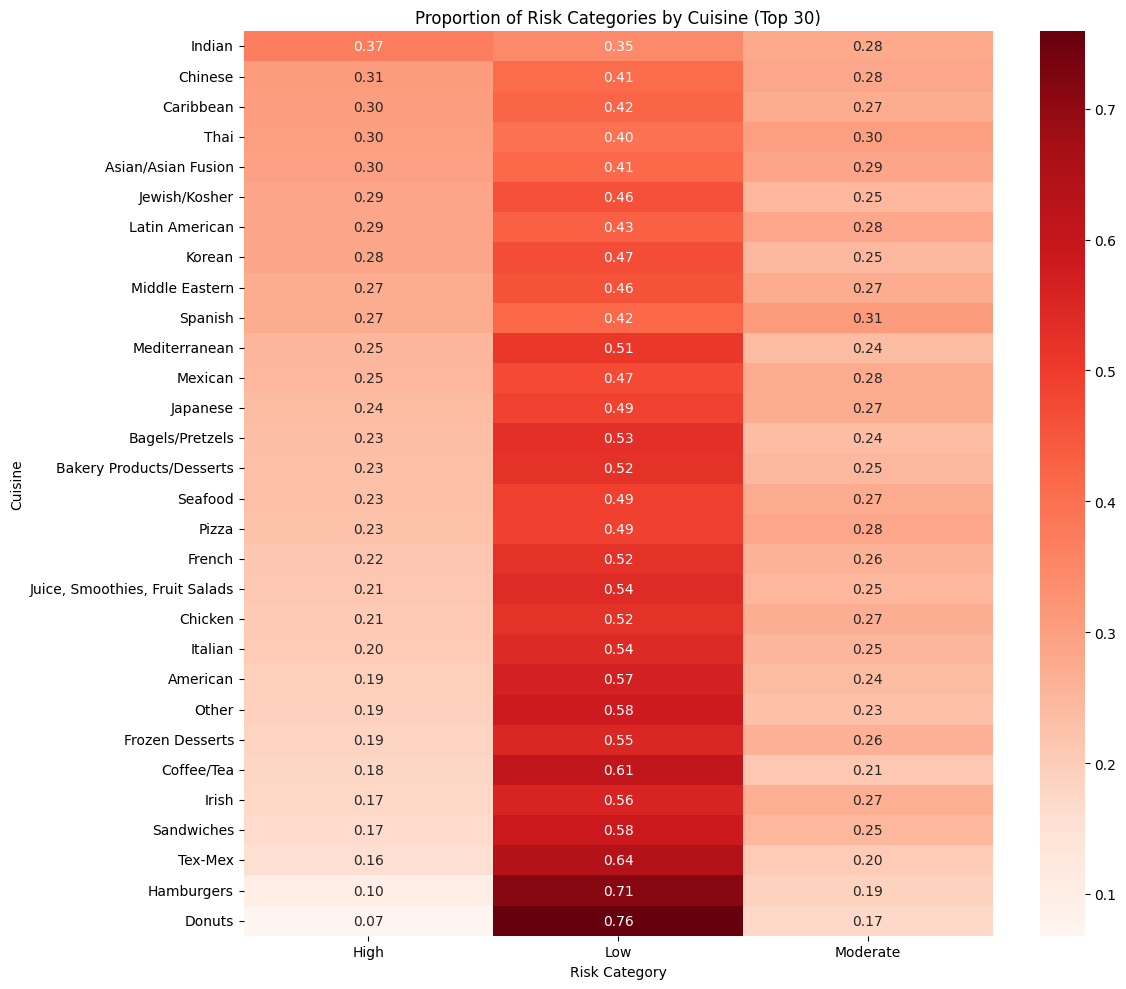

In [43]:
# Limit to cuisines with enough samples (e.g., >100 entries)
cuisine_counts = data_transformed['cuisine_description'].value_counts()
top_30_cuisines = cuisine_counts[cuisine_counts > 100].head(30).index
filtered = data_transformed[data_transformed['cuisine_description'].isin(top_30_cuisines)]

# Cross-tab normalized by row
cuisine_risk = pd.crosstab(
    filtered['cuisine_description'],
    filtered['risk_category'],
    normalize='index'
).sort_values(by='High', ascending=False)

import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(cuisine_risk, annot=True, fmt=".2f", cmap="Reds")
plt.title("Proportion of Risk Categories by Cuisine (Top 30)")
plt.xlabel("Risk Category")
plt.ylabel("Cuisine")
plt.tight_layout()
plt.show()


**Conclusion** I will not take in account the cuisine because it seems there is not much information gain to the model, since there is no clear difference.

##### 2.4.6. **Analyse inspection_type**

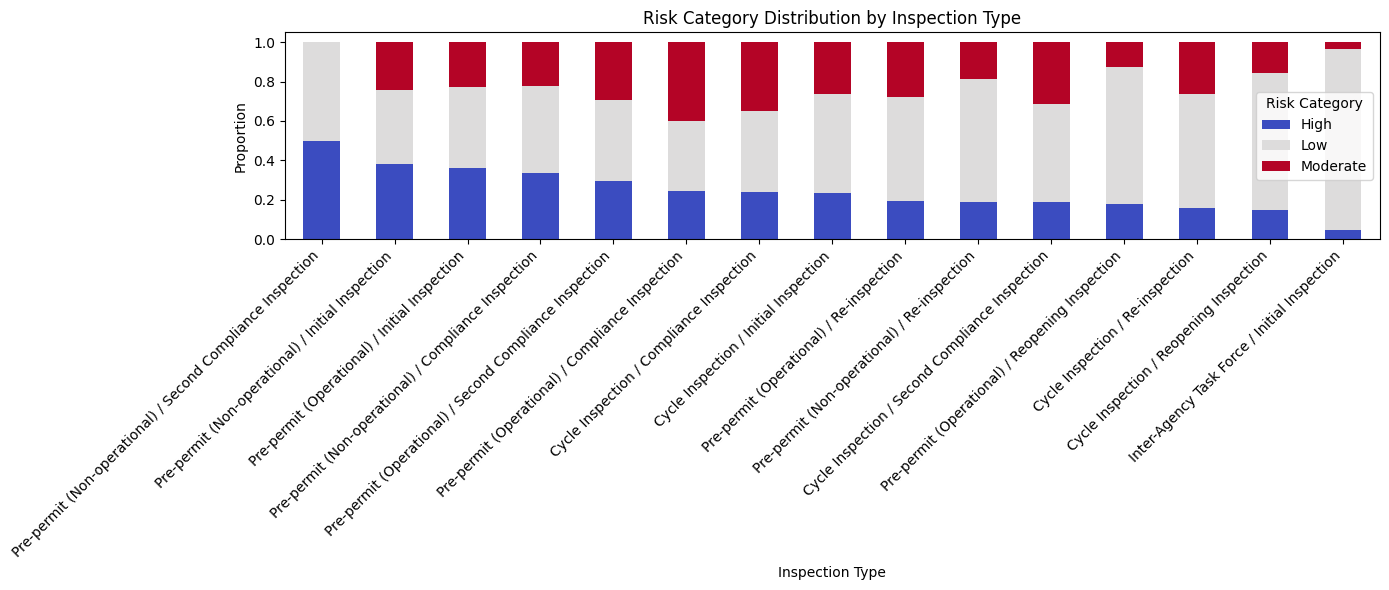

In [44]:
# Cross-tab: risk category distribution per inspection type (normalized)
insp_risk_dist = pd.crosstab(
    data_transformed['inspection_type'],
    data_transformed['risk_category'],
    normalize='index'
).sort_values(by='High', ascending=False)

# Plot
insp_risk_dist.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(14, 6))
plt.title("Risk Category Distribution by Inspection Type")
plt.ylabel("Proportion")
plt.xlabel("Inspection Type")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Risk Category")
plt.tight_layout()
plt.show()

##### 2.4.7. **Temporal features**

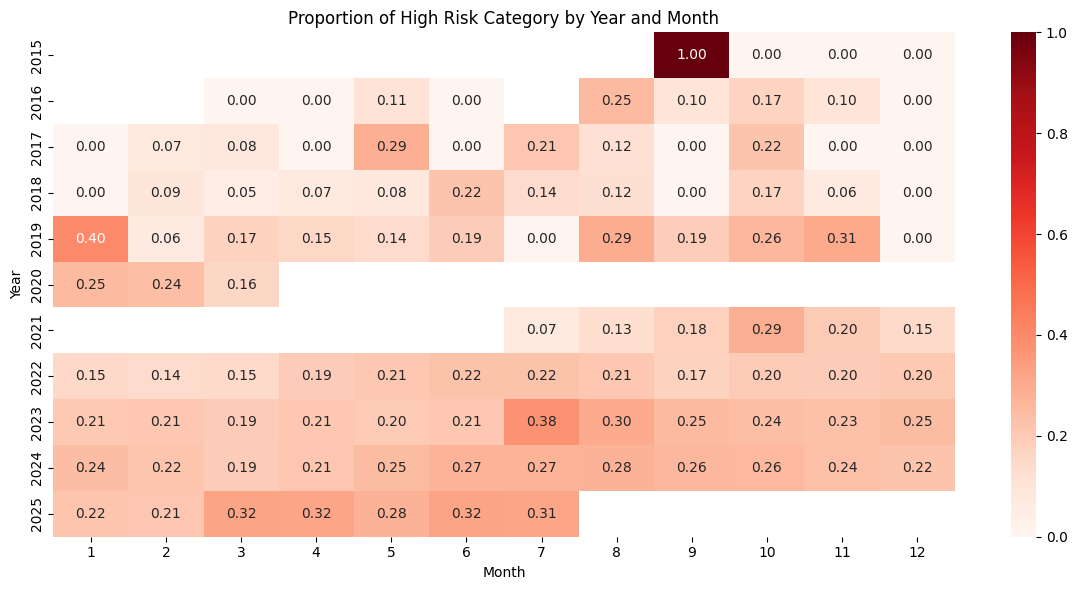

In [45]:
data_transformed['month'] = data_transformed['inspection_date'].dt.month
data_transformed['year'] = data_transformed['inspection_date'].dt.year

# Cross-tab: proportion of HIGH risk per month/year
heat_data = pd.crosstab(
    data_transformed['year'],
    data_transformed['month'],
        values=(data_transformed['risk_category'] == 'High'),
    aggfunc='mean'
)

plt.figure(figsize=(12, 6))
sns.heatmap(heat_data, cmap='Reds', annot=True, fmt=".2f")
plt.title("Proportion of High Risk Category by Year and Month")
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

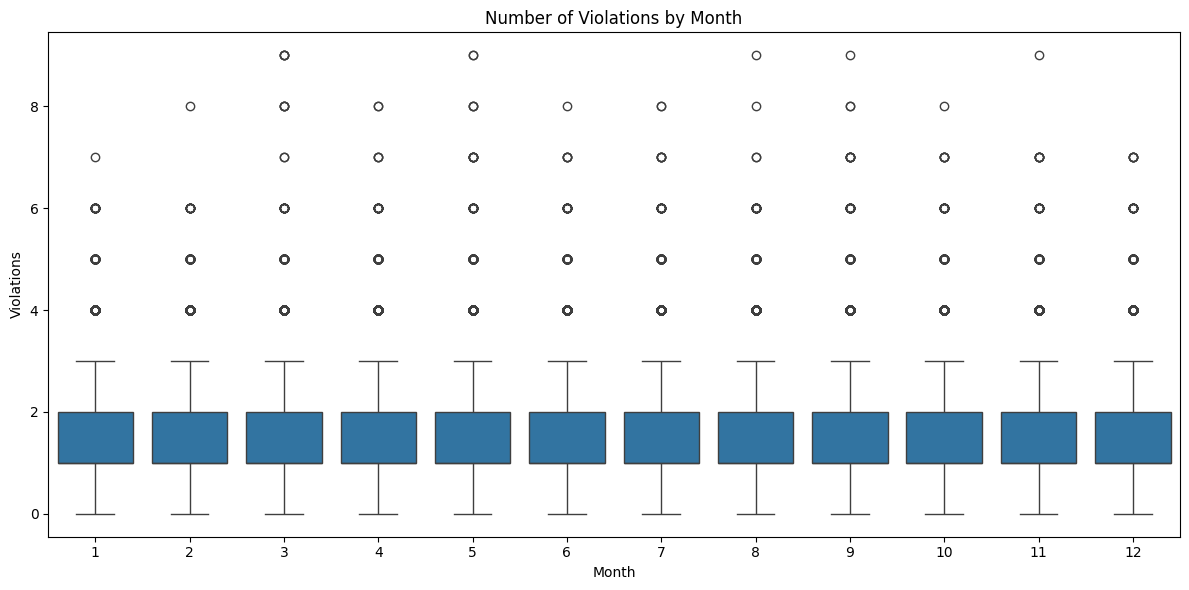

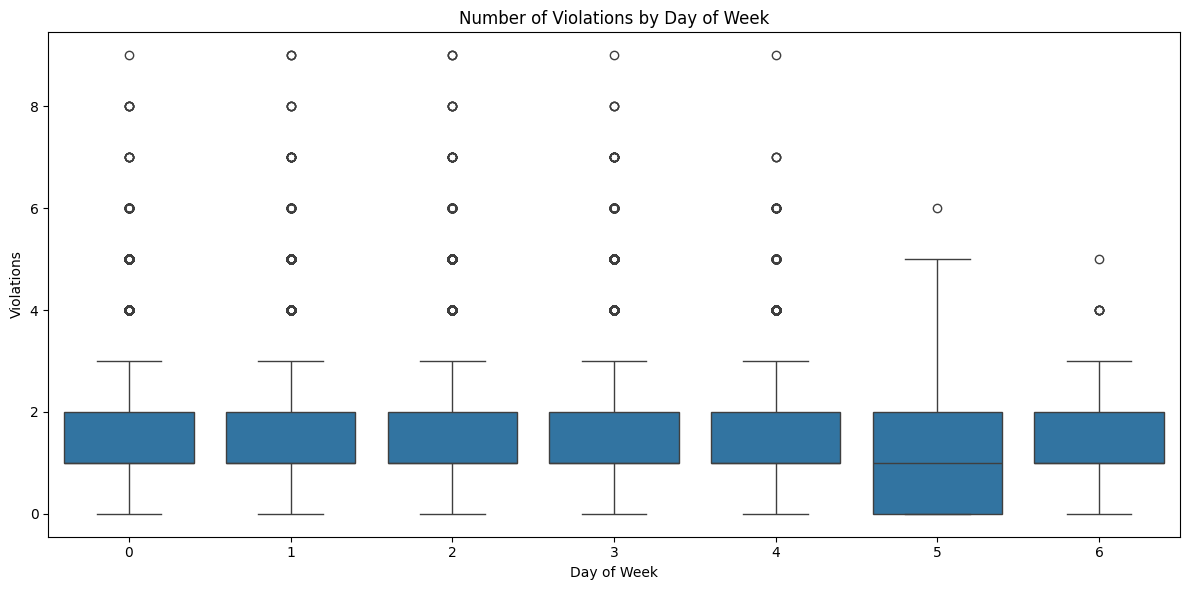

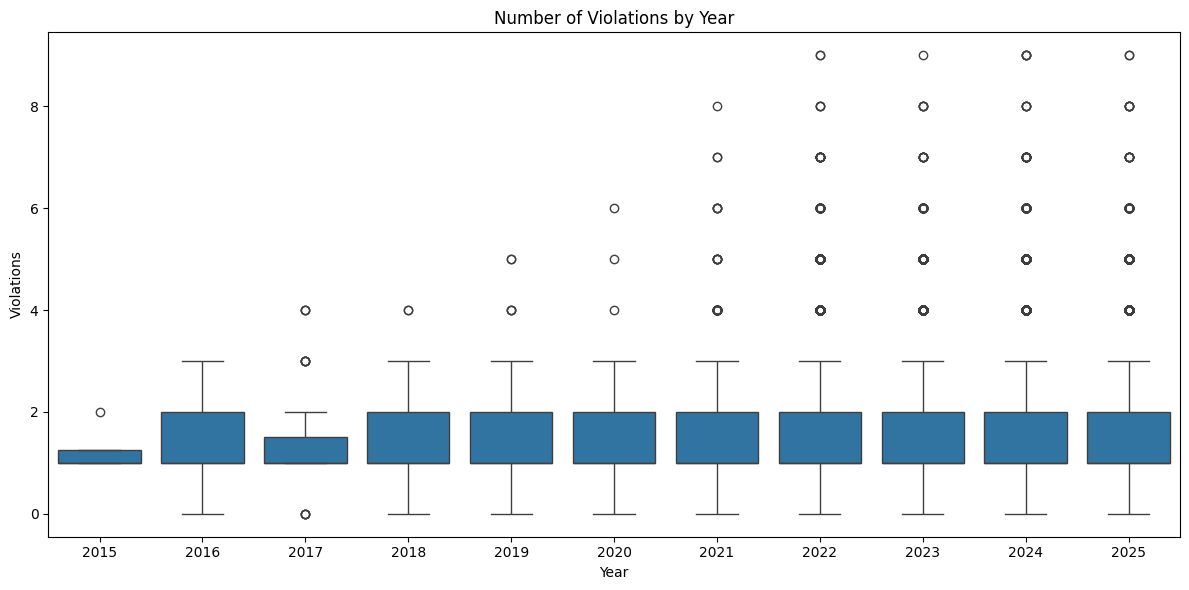

In [46]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_transformed, x='month', y='nb_violations')
plt.title("Number of Violations by Month")
plt.xlabel("Month")
plt.ylabel("Violations")
plt.tight_layout()
plt.show()

# By day of week
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_transformed, x='day_of_week', y='nb_violations')
plt.title("Number of Violations by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Violations")
plt.tight_layout()
plt.show()


# bY year
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_transformed, x='year', y='nb_violations')
plt.title("Number of Violations by Year")
plt.xlabel("Year")
plt.ylabel("Violations")
plt.tight_layout()
plt.show()

##### 2.4.8. **Violation Category features**

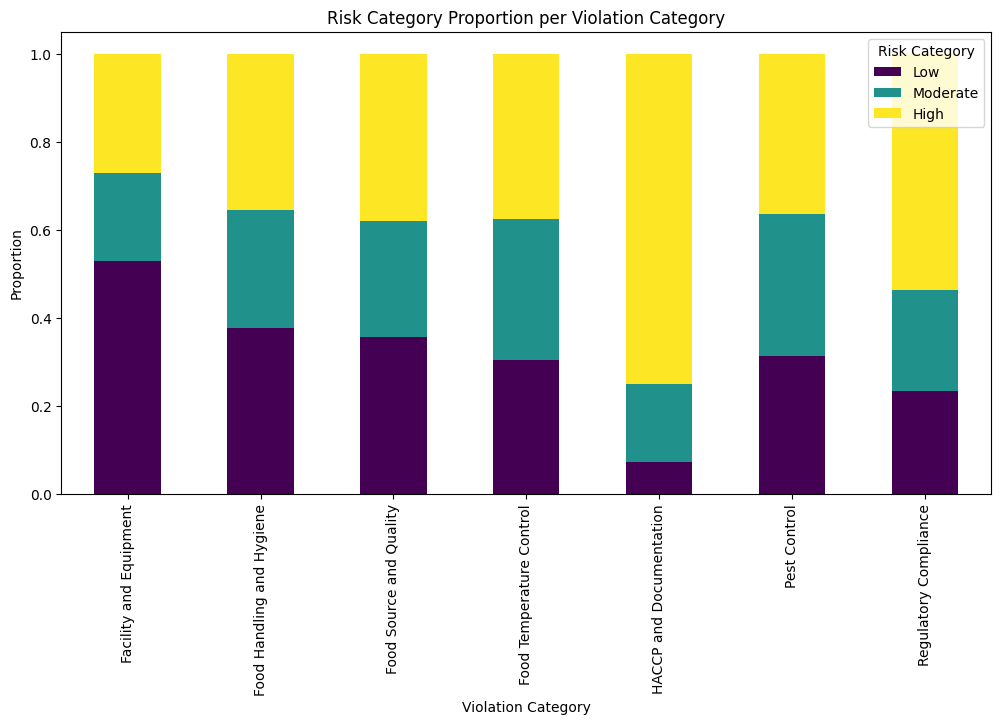

In [49]:
viol_cat = pd.crosstab(data_final['violation_category'], data_final['risk_category'], normalize='index')
viol_cat[['Low', 'Moderate', 'High']].plot(kind='bar', stacked=True, figsize=(12,6), colormap='viridis')
plt.title("Risk Category Proportion per Violation Category")
plt.xlabel("Violation Category")
plt.ylabel("Proportion")
plt.legend(title="Risk Category")
plt.show()

### 2.5. Encode Features

Based on the previous analysis, the features that for certain can be usefull would be:

* violation_code -> one hot encoding
* nb_violations
* nb_critical_flags
* action -> needs to be encoded
* inspection_type -> needs to be encoded

Doubt - cuisine_description, boro and month

##### 2.5.1. **Encode violation code**

In [50]:
df_temp = data_final[['camis', 'inspection_date', 'violation_code']].dropna()
df_violaton_code_dummies = pd.get_dummies(df_temp['violation_code'], prefix='vc')
df_violaton_code_enc = pd.concat([df_temp[['camis', 'inspection_date']], df_violaton_code_dummies], axis=1)
df_violaton_code_enc = df_violaton_code_enc.groupby(['camis', 'inspection_date'], as_index=False).sum().fillna(0)
data_transformed = data_transformed.merge(df_violaton_code_enc, on=['camis', 'inspection_date'], how='left')

##### 2.5.2. **Encode remaining columns**

In [51]:
# lets encode inspection_type
enc_insp = LabelEncoder()
data_transformed['inspection_type_enc'] = enc_insp.fit_transform(data_transformed['inspection_type'].astype(str))
data_transformed[['inspection_type_enc', "inspection_type"]].drop_duplicates()

,inspection_type_enc,inspection_type
0,1,Cycle Inspection / Initial Inspection
4,2,Cycle Inspection / Re-inspection
387,0,Cycle Inspection / Compliance Inspection
388,4,Cycle Inspection / Second Compliance Inspection
549,3,Cycle Inspection / Reopening Inspection
754,5,Inter-Agency Task Force / Initial Inspection
18990,12,Pre-permit (Operational) / Re-inspection
19860,7,Pre-permit (Non-operational) / Initial Inspection
20808,10,Pre-permit (Operational) / Compliance Inspection
20987,11,Pre-permit (Operational) / Initial Inspection


In [52]:
# lets encode action
enc_action = LabelEncoder()
data_transformed['action_enc'] = enc_action.fit_transform(data_transformed['action'].astype(str))
data_transformed[['action_enc', "action"]].drop_duplicates()

,action_enc,action
0,0,Establishment Closed by DOHMH. Violations were...
1,4,Violations were cited in the following area(s).
114,3,No violations were recorded at the time of thi...
549,1,Establishment re-closed by DOHMH.
550,2,Establishment re-opened by DOHMH.


In [53]:
# lets encode cuisine_description
enc_cuisine = LabelEncoder()
data_transformed['cuisine_encoded'] = enc_cuisine.fit_transform(data_transformed['cuisine_description'].astype(str))
data_transformed[['cuisine_encoded', "cuisine_description"]].drop_duplicates()

,cuisine_encoded,cuisine_description
0,7,Bakery Products/Desserts
3,46,Irish
4,71,Sandwiches
9,33,Frozen Desserts
10,2,American
...,...,...
23853,10,Basque
23916,60,Not Listed/Not Applicable
36666,53,Lebanese
47009,3,Armenian


In [54]:
# lets encode boro
enc_boro = LabelEncoder()
data_transformed['boro_encoded'] = enc_boro.fit_transform(data_transformed['boro'].astype(str))
data_transformed[['boro_encoded', "boro"]].drop_duplicates()

,boro_encoded,boro
0,0,Bronx
3,2,Manhattan
4,1,Brooklyn
19,3,Queens
28,4,Staten Island


In [55]:
df_temp = data_final[['camis', 'inspection_date', 'violation_category']].dropna()
df_violaton_category_dummies = pd.get_dummies(df_temp['violation_category'], prefix='vc')
df_violaton_category_enc = pd.concat([df_temp[['camis', 'inspection_date']], df_violaton_category_dummies], axis=1)
df_violaton_category_enc = df_violaton_category_enc.groupby(['camis', 'inspection_date'], as_index=False).sum().fillna(0)
data_transformed = data_transformed.merge(df_violaton_category_enc, on=['camis', 'inspection_date'], how='left')

## 3. Modelling

In [56]:
data_transformed.columns

Index(['camis', 'inspection_date', 'boro', 'cuisine_description', 'action',
       'nb_violations', 'nb_critical_flags', 'inspection_type',
       'nb_past_inspections', 'risk_category', 'month', 'year', 'day_of_week',
       'nb_non_critical_flags', 'action_simplified', 'vc_02A', 'vc_02B',
       'vc_02C', 'vc_02D', 'vc_02F', 'vc_02G', 'vc_02H', 'vc_02I', 'vc_03A',
       'vc_03B', 'vc_03C', 'vc_03D', 'vc_03E', 'vc_03F', 'vc_03G', 'vc_03I',
       'vc_04A', 'vc_04B', 'vc_04C', 'vc_04D', 'vc_04E', 'vc_04F', 'vc_04H',
       'vc_04J', 'vc_04K', 'vc_04L', 'vc_04M', 'vc_04N', 'vc_04O', 'vc_04P',
       'vc_05A', 'vc_05B', 'vc_05C', 'vc_05D', 'vc_05E', 'vc_05F', 'vc_05H',
       'vc_06A', 'vc_06B', 'vc_06C', 'vc_06D', 'vc_06E', 'vc_06F', 'vc_06G',
       'vc_06H', 'vc_06I', 'vc_07A', 'vc_08A', 'vc_08B', 'vc_08C', 'vc_09A',
       'vc_09B', 'vc_09C', 'vc_09D', 'vc_09E', 'vc_10A', 'vc_10B', 'vc_10C',
       'vc_10D', 'vc_10E', 'vc_10F', 'vc_10G', 'vc_10H', 'vc_10I', 'vc_10J',
       'vc_18-1

In [71]:
drop_columns = ['camis', 'inspection_date', 'boro', 'cuisine_description', 'action', 'inspection_type', 'year', 'day_of_week', 'action_simplified', 'nb_non_critical_flags']
data_model = data_transformed.drop(columns=drop_columns).drop_duplicates()

### 3.1.  Handle inbalance data

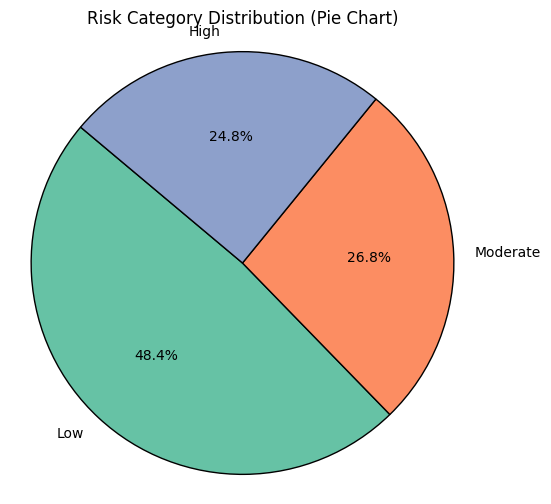

In [72]:
risk_counts = data_model['risk_category'].value_counts().reindex(['Low', 'Moderate', 'High'])

# Define colors
colors = ['#66c2a5', '#fc8d62', '#8da0cb']

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    risk_counts,
    labels=risk_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Risk Category Distribution (Pie Chart)')
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular.
plt.show()

### 3.2.  Train Model

In [73]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint

In [74]:
data_model['risk_category_encoded'] = LabelEncoder().fit_transform(data_model['risk_category'])

X = data_model.drop(columns=['risk_category', 'risk_category_encoded'])
y = data_model['risk_category_encoded']

In [75]:
data_model[['risk_category', 'risk_category_encoded']].drop_duplicates()

,risk_category,risk_category_encoded
0,Moderate,2
1,High,0
2,Low,1


VERSION 2

In [86]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [87]:
rf = RandomForestClassifier(class_weight='balanced', random_state=40)

# Define hyperparameter search space
param_dist = {
    'n_estimators': randint(200, 1000),               # Broader range for potentially better models
    'max_depth': randint(10, 50),                     # Allow deeper trees
    'min_samples_split': randint(2, 20),              # Explore more splitting strategies
    'min_samples_leaf': randint(1, 10),               # Try slightly larger leaves
    'max_features': ['sqrt', 'log2', None]            # Feature sampling strategies
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  # Number of models to try
    scoring='f1_macro',
    cv=5,
    verbose=1,
    random_state=40,
    n_jobs=-1
)

# Fit search
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_
print("✅ Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
importances = best_model.feature_importances_

# Create a DataFrame
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display top features
print(feature_importances.head(10))

# Optional: Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(30))
plt.title('Top 20 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

### VERSION 1

In [ ]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Define hyperparameter search space
param_dist = {
    'n_estimators': randint(200, 1000),               # Broader range for potentially better models
    'max_depth': randint(10, 50),                     # Allow deeper trees
    'min_samples_split': randint(2, 20),              # Explore more splitting strategies
    'min_samples_leaf': randint(1, 10),               # Try slightly larger leaves
    'max_features': ['sqrt', 'log2', None]            # Feature sampling strategies
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  # Number of models to try
    scoring='f1_macro',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit search
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_
print("✅ Best Parameters:", random_search.best_params_)

                         Feature  Importance
1              nb_critical_flags    0.192967
0                  nb_violations    0.149688
74                    action_enc    0.073528
75               cuisine_encoded    0.060781
81               vc_Pest Control    0.060046
77  vc_Food Handling and Hygiene    0.050263
3                          month    0.047491
73           inspection_type_enc    0.042256
79   vc_Food Temperature Control    0.031635
76     vc_Facility and Equipment    0.030838


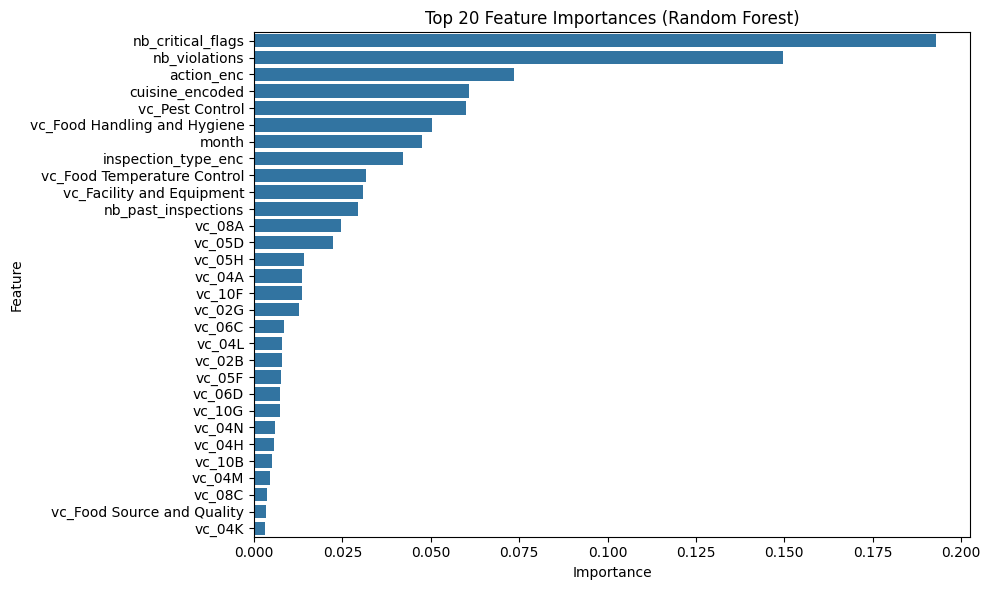

In [70]:
importances = best_model.feature_importances_

# Create a DataFrame
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display top features
print(feature_importances.head(10))

# Optional: Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(30))
plt.title('Top 20 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

In [65]:
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5781609195402299
Macro F1 Score: 0.5497853739054818
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.54      0.58      2539
           1       0.65      0.73      0.69      4351
           2       0.39      0.37      0.38      2680

    accuracy                           0.58      9570
   macro avg       0.56      0.55      0.55      9570
weighted avg       0.57      0.58      0.57      9570



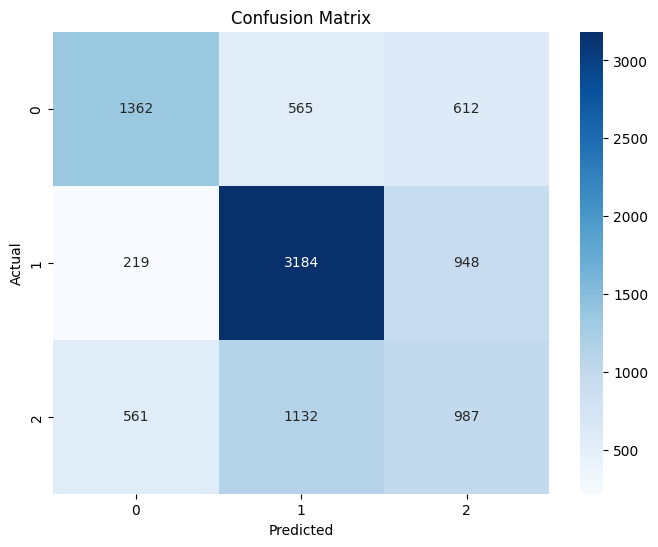

In [66]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=best_model.classes_, yticklabels=best_model.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [ ]:
# Mapping high-risk by borough
df['predicted_risk'] = search.predict(X)
high_risk = df[df['predicted_risk'] == 'High Risk']
plt.figure(figsize=(6,4))
sns.countplot(data=high_risk, x='boro', order=high_risk['boro'].value_counts().index)
plt.title("High-Risk Inspections by Borough")
plt.xlabel("Borough")
plt.ylabel("Count")
plt.show()